# Import required libraries to run the naive baseline

In [1]:

import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from collections import OrderedDict
import matplotlib.pyplot as plt
import pickle

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v3_small

In [3]:
#############################################
# FUNCTIONS
#############################################

def show_images(df, image_dir, n_images=5, title='None'):
    N = len(df)
    plt.figure(figsize=(15, (N//5 + 1)*3))
    for i in range(N):
        plt.subplot(N//5 + 1, n_images, i + 1)
        img = Image.open(f"{image_dir}/{df.iloc[i]['filename']}")
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

In [4]:
df_train = pd.read_csv("data/listes_training/data_100K/train_100K.csv", delimiter=' ')
df_test = pd.read_csv("data/listes_training/data_100K/test_students.csv", delimiter=' ')

image_dir = "data/crops_100K"

df_train.head(-10)

,filename,FaceOcclusion,gender
0,database1/img00011271.jpg,0.019,0.999
1,database1/img00012471.jpg,0.035,1.000
2,database1/img00008127.jpg,0.127,0.001
3,database1/img00008972.jpg,0.014,0.999
4,database1/img00028187.jpg,0.346,0.982
...,...,...,...
101330,database3/database3/m.01drbr/59-FaceId-0_align...,0.000,1.000
101331,database3/database3/m.01drbr/69-FaceId-0_align...,0.021,0.998
101332,database3/database3/m.01drbr/7-FaceId-0_align.jpg,0.008,1.000
101333,database3/database3/m.01drbr/71-FaceId-0_align...,0.005,1.000


In [8]:
df_train = df_train.dropna()
df_test = df_test.dropna()

# 1. le problème

In [6]:
plt.figure(figsize=(12, 6))
cross_table.plot(kind='bar', stacked=True, color=['orange', 'blue'])
plt.title('Répartition des genres par FaceOcclusion (en pourcentage)', fontsize=16)
plt.xlabel('FaceOcclusion', fontsize=14)
plt.ylabel('Pourcentage', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=12)
plt.legend(title='Genre', labels=['Femme', 'Homme'], fontsize=12)
plt.show()

NameError: name 'cross_table' is not defined

<Figure size 1200x600 with 0 Axes>

# 2. resampling

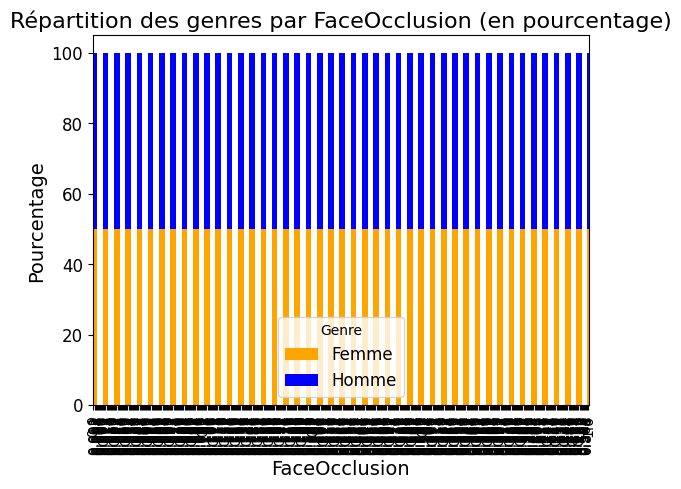

In [5]:
import pandas as pd
from sklearn.utils import resample
import matplotlib.pyplot as plt

# Charger les données
df_train = pd.read_csv("data/listes_training/data_100K/train_100K.csv", delimiter=' ')
df_test = pd.read_csv("data/listes_training/data_100K/test_students.csv", delimiter=' ')

# Initialiser une liste pour stocker les données équilibrées
balanced_data_list = []

# Extraire les niveaux d'occultation uniques
unique_occlusions = df_train['FaceOcclusion'].unique()

# Définir le seuil pour la classification du genre
threshold = 0.5

# Équilibrer les données pour chaque niveau d'occultation
for occ in unique_occlusions:
    # Sélectionner les données pour un niveau d'occultation spécifique
    data_occ = df_train[df_train['FaceOcclusion'] == occ]
    
    # Séparer en fonction de la classe de genre
    data_male = data_occ[data_occ['gender'] >= threshold]
    data_female = data_occ[data_occ['gender'] < threshold]
    
    # Vérifier que les deux sous-ensembles contiennent des données
    if len(data_male) > 0 and len(data_female) > 0:
        # Rééchantillonnage pour équilibrer les classes de genre
        if len(data_male) >= len(data_female):
            data_female_resampled = resample(data_female, replace=True, n_samples=len(data_male), random_state=42)
            balanced_data = pd.concat([data_male, data_female_resampled])
        else:
            data_male_resampled = resample(data_male, replace=True, n_samples=len(data_female), random_state=42)
            balanced_data = pd.concat([data_female, data_male_resampled])
        
        balanced_data_list.append(balanced_data)

# Combiner toutes les données équilibrées en un seul DataFrame
balanced_data_combined = pd.concat(balanced_data_list)

# Sauvegarder les données équilibrées dans un nouveau fichier CSV
balanced_data_combined.to_csv('balanced_train_resampling_100K.csv', index=False)

# Vérification de la nouvelle répartition
# Créer une nouvelle colonne pour la classification du genre
balanced_data_combined['gender_class'] = balanced_data_combined['gender'].apply(lambda x: 'Homme' if x >= threshold else 'Femme')

# Calculer le tableau croisé
cross_table = pd.crosstab(balanced_data_combined['FaceOcclusion'], balanced_data_combined['gender_class'], normalize='index') * 100

# Plot
cross_table.plot(kind='bar', stacked=True, color=['orange', 'blue'])
plt.title('Répartition des genres par FaceOcclusion (en pourcentage)', fontsize=16)
plt.xlabel('FaceOcclusion', fontsize=14)
plt.ylabel('Pourcentage', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=12)
plt.legend(title='Genre', labels=['Femme', 'Homme'], fontsize=12)
plt.show()

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Charger les données équilibrées
balanced_data_combined = pd.read_csv('balanced_train_resampling_100K.csv')

# Diviser les données en ensembles d'entraînement et de validation, 80% pour l'entraînement et 20% pour la validation
df_train, df_val = train_test_split(balanced_data_combined, test_size=0.2, random_state=42)

# Réinitialiser les index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

# Sauvegarder les nouveaux ensembles
df_train.to_csv('balanced_train_remaining.csv', index=False)
df_val.to_csv('balanced_val_20K.csv', index=False)

# Vérifier les résultats
print("Taille de l'ensemble d'entraînement :", len(df_train))
print("Taille de l'ensemble de validation :", len(df_val))

print("\nEnsemble d'entraînement:")
print(df_train.head())

print("\nEnsemble de validation:")
print(df_val.head())

Taille de l'ensemble d'entraînement : 116153
Taille de l'ensemble de validation : 29039

Ensemble d'entraînement:
                                            filename  FaceOcclusion  gender
0                          database1/img00002089.jpg          0.032   1.000
1  database3/database3/m.016gj9/80-FaceId-0_align...          0.056   0.001
2  database3/database3/m.016_mj/77-FaceId-0_align...          0.014   0.994
3                          database1/img00022842.jpg          0.111   0.000
4  database3/database3/m.01bj_5/48-FaceId-0_align...          0.042   0.008

Ensemble de validation:
                                            filename  FaceOcclusion  gender
0  database3/database3/m.01bm50/80-FaceId-0_align...          0.005   0.998
1                          database1/img00008376.jpg          0.026   0.003
2                          database1/img00015390.jpg          0.023   0.000
3  database3/database3/m.01c2_j/36-FaceId-0_align...          0.293   0.000
4  database3/database3/m.

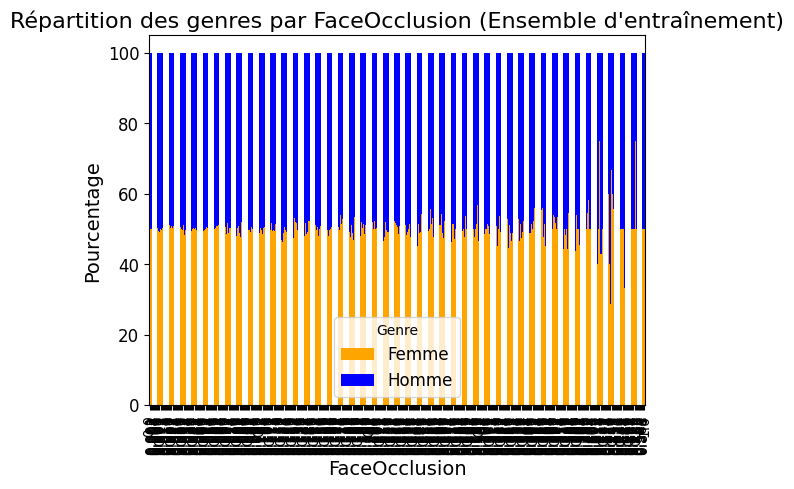

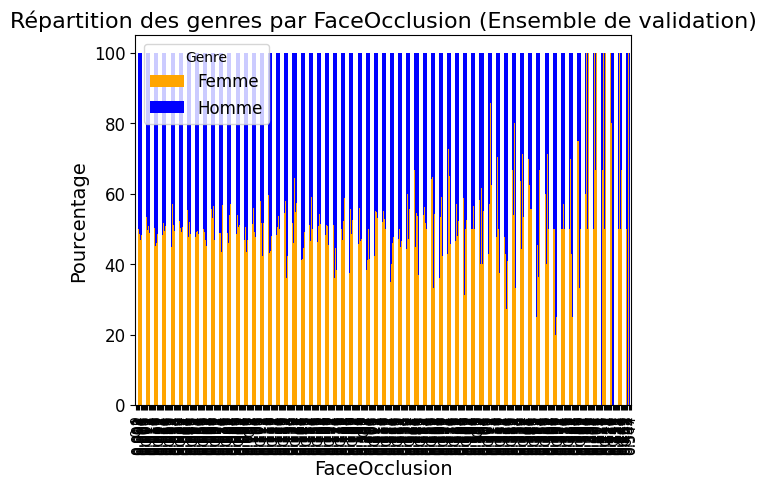

In [7]:
# Vérification de la nouvelle répartition
# Créer une nouvelle colonne pour la classification du genre
df_train['gender_class'] = df_train['gender'].apply(lambda x: 'Homme' if x >= threshold else 'Femme')
df_val['gender_class'] = df_val['gender'].apply(lambda x: 'Homme' if x >= threshold else 'Femme')

# Calculer le tableau croisé pour l'ensemble d'entraînement
cross_table_train = pd.crosstab(df_train['FaceOcclusion'], df_train['gender_class'], normalize='index') * 100

# Plot pour l'ensemble d'entraînement
cross_table_train.plot(kind='bar', stacked=True, color=['orange', 'blue'])
plt.title('Répartition des genres par FaceOcclusion (Ensemble d\'entraînement)', fontsize=16)
plt.xlabel('FaceOcclusion', fontsize=14)
plt.ylabel('Pourcentage', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=12)
plt.legend(title='Genre', labels=['Femme', 'Homme'], fontsize=12)
plt.show()

# Calculer le tableau croisé pour l'ensemble de validation
cross_table_val = pd.crosstab(df_val['FaceOcclusion'], df_val['gender_class'], normalize='index') * 100

# Plot pour l'ensemble de validation
cross_table_val.plot(kind='bar', stacked=True, color=['orange', 'blue'])
plt.title('Répartition des genres par FaceOcclusion (Ensemble de validation)', fontsize=16)
plt.xlabel('FaceOcclusion', fontsize=14)
plt.ylabel('Pourcentage', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=12)
plt.legend(title='Genre', labels=['Femme', 'Homme'], fontsize=12)
plt.show()

Quand on équilibre les données d'entrainement puis on les partag

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Valeurs manquantes après dropna:
filename         0
FaceOcclusion    0
gender           0
dtype: int64
filename    0
dtype: int64


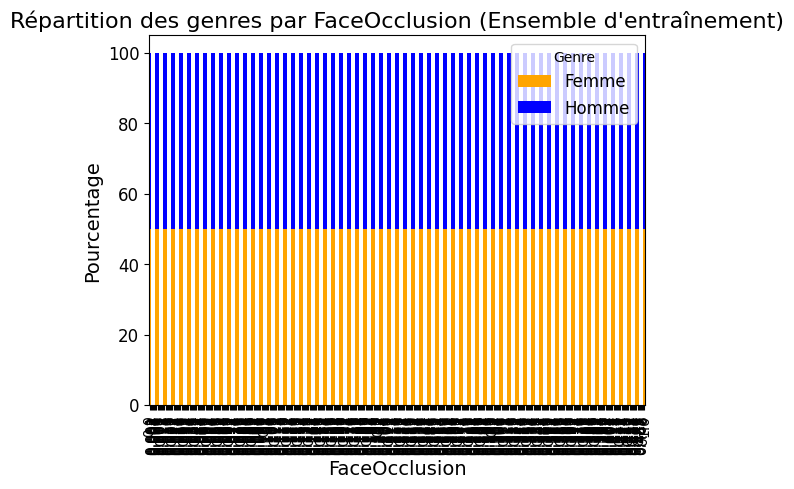

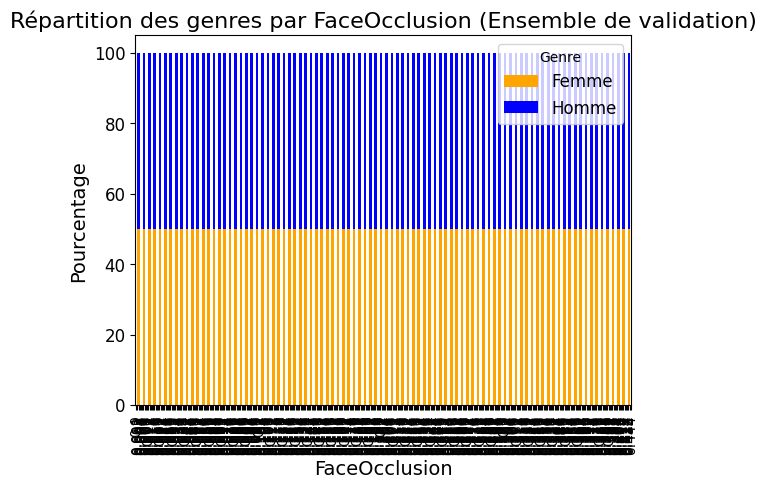

In [13]:
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Charger les données
df_train = pd.read_csv("data/listes_training/data_100K/train_100K.csv", delimiter=' ')
df_test = pd.read_csv("data/listes_training/data_100K/test_students.csv", delimiter=' ')

# Supprimer les valeurs manquantes
df_train = df_train.dropna()
df_test = df_test.dropna()

# Vérifier qu'il n'y a pas de valeurs manquantes après dropna
print("Valeurs manquantes après dropna:")
print(df_train.isnull().sum())
print(df_test.isnull().sum())

# Filtrer les classes de FaceOcclusion ayant moins de deux instances
face_occlusion_counts = df_train['FaceOcclusion'].value_counts()
valid_occlusions = face_occlusion_counts[face_occlusion_counts > 1].index
df_train = df_train[df_train['FaceOcclusion'].isin(valid_occlusions)]

# Diviser les données en entraînement (70%) et validation (30%) en utilisant la stratification
train_data, val_data = train_test_split(df_train, test_size=0.3, random_state=42, stratify=df_train['FaceOcclusion'])

# Fonction pour rééquilibrer les données
def balance_data(data, threshold=0.5):
    balanced_data_list = []
    unique_occlusions = data['FaceOcclusion'].unique()

    for occ in unique_occlusions:
        data_occ = data[data['FaceOcclusion'] == occ]
        
        data_male = data_occ[data_occ['gender'] >= threshold]
        data_female = data_occ[data_occ['gender'] < threshold]
        
        if len(data_male) > 0 and len(data_female) > 0:
            if len(data_male) >= len(data_female):
                data_female_resampled = resample(data_female, replace=True, n_samples=len(data_male), random_state=42)
                balanced_data = pd.concat([data_male, data_female_resampled])
            else:
                data_male_resampled = resample(data_male, replace=True, n_samples=len(data_female), random_state=42)
                balanced_data = pd.concat([data_female, data_male_resampled])
            
            balanced_data_list.append(balanced_data)

    return pd.concat(balanced_data_list)

# Rééquilibrer les données d'entraînement
balanced_train_data = balance_data(train_data)

# Rééquilibrer les données de validation (optionnel)
balanced_val_data = balance_data(val_data)

# Sauvegarder les données équilibrées dans des nouveaux fichiers CSV
balanced_train_data.to_csv('resampling_balanced_train_data.csv', index=False)
balanced_val_data.to_csv('resampling_balanced_val_data.csv', index=False)

# Vérification de la nouvelle répartition
def plot_gender_distribution(data, title):
    threshold = 0.5
    data['gender_class'] = data['gender'].apply(lambda x: 'Homme' if x >= threshold else 'Femme')
    cross_table = pd.crosstab(data['FaceOcclusion'], data['gender_class'], normalize='index') * 100
    cross_table.plot(kind='bar', stacked=True, color=['orange', 'blue'])
    plt.title(title, fontsize=16)
    plt.xlabel('FaceOcclusion', fontsize=14)
    plt.ylabel('Pourcentage', fontsize=14)
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(fontsize=12)
    plt.legend(title='Genre', labels=['Femme', 'Homme'], fontsize=12)
    plt.show()

# Plot pour l'ensemble d'entraînement
plot_gender_distribution(balanced_train_data, "Répartition des genres par FaceOcclusion (Ensemble d'entraînement)")

# Plot pour l'ensemble de validation
plot_gender_distribution(balanced_val_data, "Répartition des genres par FaceOcclusion (Ensemble de validation)")


In [14]:
# Préparer les données pour l'équilibrage
X_train = train_data.drop(columns=['gender'])
y_train = train_data['gender']

X_val = val_data.drop(columns=['gender'])
y_val = val_data['gender']

In [15]:
# Fonction pour sauvegarder les ensembles équilibrés
def save_balanced_data(X, y, filename):
    balanced_data = X.copy()
    balanced_data['gender'] = y
    balanced_data.to_csv(filename, index=False)

In [ ]:
# Random Undersampling (RUS)
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)
save_balanced_data(X_rus, y_rus, 'balanced_train_data_rus.csv'

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE
from imblearn.combine import SMOTETomek

# Charger les données
df_train = pd.read_csv("data/listes_training/data_100K/train_100K.csv", delimiter=' ')
df_test = pd.read_csv("data/listes_training/data_100K/test_students.csv", delimiter=' ')

# Supprimer les valeurs manquantes
df_train = df_train.dropna()
df_test = df_test.dropna()

# Filtrer les classes de FaceOcclusion ayant moins de deux instances
face_occlusion_counts = df_train['FaceOcclusion'].value_counts()
valid_occlusions = face_occlusion_counts[face_occlusion_counts > 1].index
df_train = df_train[df_train['FaceOcclusion'].isin(valid_occlusions)]

# Diviser les données en entraînement (70%) et validation (30%) en utilisant la stratification
train_data, val_data = train_test_split(df_train, test_size=0.3, random_state=42, stratify=df_train['FaceOcclusion'])

# Préparer les données pour l'équilibrage
X_train = train_data.drop(columns=['gender'])
y_train = train_data['gender']

X_val = val_data.drop(columns=['gender'])
y_val = val_data['gender']

# Fonction pour sauvegarder les ensembles équilibrés
def save_balanced_data(X, y, filename):
    balanced_data = X.copy()
    balanced_data['gender'] = y
    balanced_data.to_csv(filename, index=False)

Dimensions des données d'entraînement après RUS: (56508, 2), (56508,)


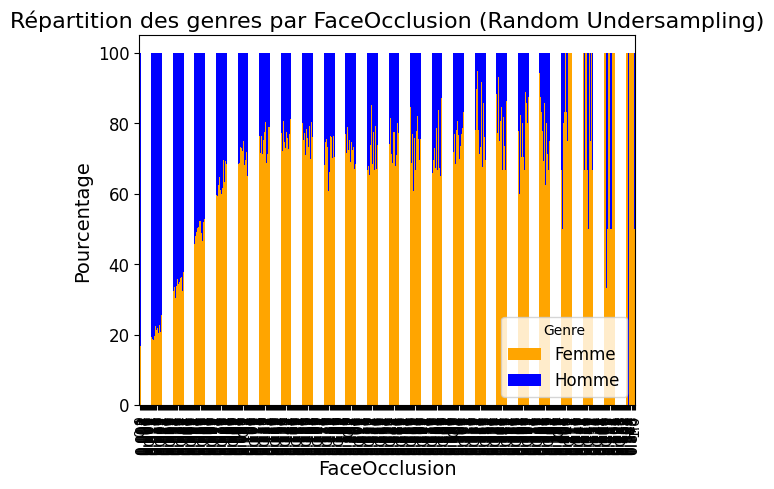

In [25]:
# Préparer les données pour l'équilibrage
X_train = train_data.drop(columns=['gender'])
y_train = train_data['gender']

# Binariser les étiquettes de genre
threshold = 0.5
y_train_binarized = (y_train >= threshold).astype(int)

# Méthode de rééquilibrage : Random Undersampling (RUS)
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train_binarized)

# Sauvegarder les données équilibrées après RUS
save_balanced_data(X_rus, y_rus, 'balanced_train_data_rus.csv')

# Vérifier les dimensions des données après RUS
print(f"Dimensions des données d'entraînement après RUS: {X_rus.shape}, {y_rus.shape}")

# Vérification de la répartition des genres après RUS
def plot_gender_distribution(X, y, title):
    data = X.copy()
    data['gender'] = y
    data['gender_class'] = data['gender'].apply(lambda x: 'Homme' if x == 1 else 'Femme')
    cross_table = pd.crosstab(data['FaceOcclusion'], data['gender_class'], normalize='index') * 100
    cross_table.plot(kind='bar', stacked=True, color=['orange', 'blue'])
    plt.title(title, fontsize=16)
    plt.xlabel('FaceOcclusion', fontsize=14)
    plt.ylabel('Pourcentage', fontsize=14)
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(fontsize=12)
    plt.legend(title='Genre', labels=['Femme', 'Homme'], fontsize=12)
    plt.show()

plot_gender_distribution(X_rus, y_rus, "Répartition des genres par FaceOcclusion (Random Undersampling)")


Dimensions des données d'entraînement après Tomek Links: (70894, 2), (70894,)


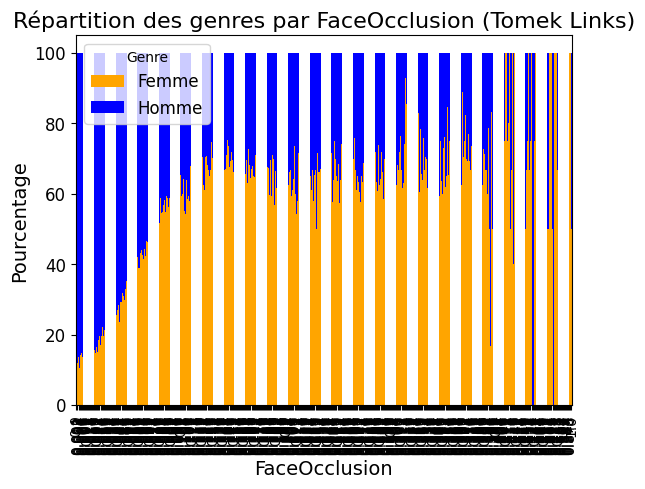

In [28]:
from imblearn.under_sampling import TomekLinks

# Binariser les étiquettes de genre
threshold = 0.5
y_train_binarized = (y_train >= threshold).astype(int)

# Exclure la colonne filename avant l'application de Tomek Links
X_train_excluded = X_train.drop(columns=['filename'])

# Méthode de rééquilibrage : Tomek Links
tl = TomekLinks()
X_tl, y_tl = tl.fit_resample(X_train_excluded, y_train_binarized)

# Ajouter de nouveau la colonne filename aux données équilibrées
X_tl['filename'] = X_train['filename'].iloc[X_tl.index]

# Sauvegarder les données équilibrées après Tomek Links
save_balanced_data(X_tl, y_tl, 'balanced_train_data_tl.csv')

# Vérifier les dimensions des données après Tomek Links
print(f"Dimensions des données d'entraînement après Tomek Links: {X_tl.shape}, {y_tl.shape}")

# Vérification de la répartition des genres après Tomek Links
plot_gender_distribution(X_tl, y_tl, "Répartition des genres par FaceOcclusion (Tomek Links)")




Dimensions des données d'entraînement après ROS: (85284, 2), (85284,)


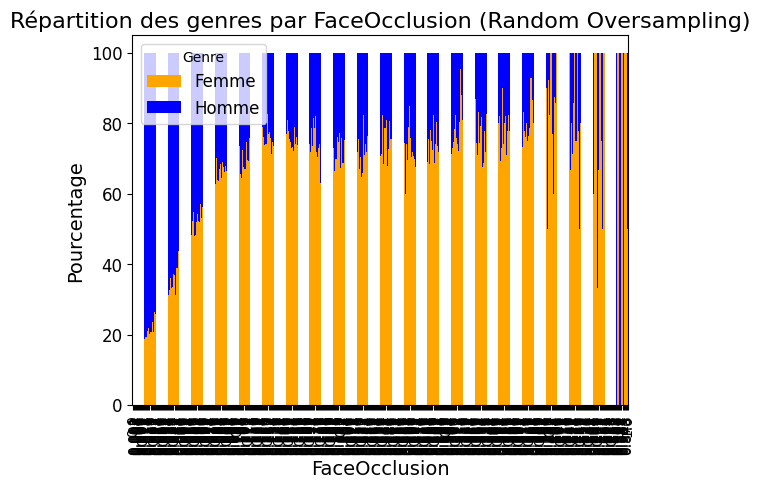

In [31]:
from imblearn.over_sampling import RandomOverSampler

# Binariser les étiquettes de genre
threshold = 0.5
y_train_binarized = (y_train >= threshold).astype(int)

# Exclure la colonne filename avant l'application de ROS
X_train_excluded = X_train.drop(columns=['filename'])

# Méthode de rééquilibrage : Random Oversampling (ROS)
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train_excluded, y_train_binarized)

# Convertir X_ros en DataFrame et réindexer correctement
X_ros = pd.DataFrame(X_ros, columns=X_train_excluded.columns)
X_ros['filename'] = X_train['filename'].values[ros.sample_indices_]

# Sauvegarder les données équilibrées après ROS
save_balanced_data(X_ros, y_ros, 'balanced_train_data_ros.csv')

# Vérifier les dimensions des données après ROS
print(f"Dimensions des données d'entraînement après ROS: {X_ros.shape}, {y_ros.shape}")

# Vérification de la répartition des genres après ROS
plot_gender_distribution(X_ros, y_ros, "Répartition des genres par FaceOcclusion (Random Oversampling)")


In [32]:
from imblearn.over_sampling import SMOTE

# Binariser les étiquettes de genre
threshold = 0.5
y_train_binarized = (y_train >= threshold).astype(int)

# Exclure la colonne filename avant l'application de SMOTE
X_train_excluded = X_train.drop(columns=['filename'])

# Méthode de rééquilibrage : SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train_excluded, y_train_binarized)

# Convertir X_smote en DataFrame et réindexer correctement
X_smote = pd.DataFrame(X_smote, columns=X_train_excluded.columns)
# Copier les valeurs de 'filename' de X_train en fonction des indices originaux
X_smote['filename'] = X_train['filename'].iloc[smote.sample_indices_].values

# Sauvegarder les données équilibrées après SMOTE
save_balanced_data(X_smote, y_smote, 'balanced_train_data_smote.csv')

# Vérifier les dimensions des données après SMOTE
print(f"Dimensions des données d'entraînement après SMOTE: {X_smote.shape}, {y_smote.shape}")

# Vérification de la répartition des genres après SMOTE
plot_gender_distribution(X_smote, y_smote, "Répartition des genres par FaceOcclusion (SMOTE)")


AttributeError: 'SMOTE' object has no attribute 'sample_indices_'

In [ ]:


# Méthode de rééquilibrage : ADASYN
adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)
save_balanced_data(X_adasyn, y_adasyn, 'balanced_train_data_adasyn.csv')

# Méthode de rééquilibrage : Borderline-SMOTE
borderline_smote = BorderlineSMOTE(random_state=42)
X_borderline_smote, y_borderline_smote = borderline_smote.fit_resample(X_train, y_train)
save_balanced_data(X_borderline_smote, y_borderline_smote, 'balanced_train_data_borderline_smote.csv')

# Méthode de rééquilibrage : SMOTE + Tomek Links
smote_tomek = SMOTETomek(random_state=42)
X_smote_tomek, y_smote_tomek = smote_tomek.fit_resample(X_train, y_train)
save_balanced_data(X_smote_tomek, y_smote_tomek, 'balanced_train_data_smote_tomek.csv')

# Fonction pour vérifier la répartition des genres par niveau de FaceOcclusion
def plot_gender_distribution(X, y, title):
    data = X.copy()
    data['gender'] = y
    threshold = 0.5
    data['gender_class'] = data['gender'].apply(lambda x: 'Homme' if x >= threshold else 'Femme')
    cross_table = pd.crosstab(data['FaceOcclusion'], data['gender_class'], normalize='index') * 100
    cross_table.plot(kind='bar', stacked=True, color=['orange', 'blue'])
    plt.title(title, fontsize=16)
    plt.xlabel('FaceOcclusion', fontsize=14)
    plt.ylabel('Pourcentage', fontsize=14)
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(fontsize=12)
    plt.legend(title='Genre', labels=['Femme', 'Homme'], fontsize=12)
    plt.show()

# Plot pour chaque méthode
plot_gender_distribution(X_rus, y_rus, "Répartition des genres par FaceOcclusion (Random Undersampling)")
plot_gender_distribution(X_tl, y_tl, "Répartition des genres par FaceOcclusion (Tomek Links)")
plot_gender_distribution(X_ros, y_ros, "Répartition des genres par FaceOcclusion (Random Oversampling)")
plot_gender_distribution(X_smote, y_smote, "Répartition des genres par FaceOcclusion (SMOTE)")
plot_gender_distribution(X_adasyn, y_adasyn, "Répartition des genres par FaceOcclusion (ADASYN)")
plot_gender_distribution(X_borderline_smote, y_borderline_smote, "Répartition des genres par FaceOcclusion (Borderline-SMOTE)")
plot_gender_distribution(X_smote_tomek, y_smote_tomek, "Répartition des genres par FaceOcclusion (SMOTE + Tomek Links)")
